In [39]:
import torch
import torch.nn as nn
from torch.optim import SGD #stochastic gradient descent
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [41]:
x, y = torch.load("C:/Users/Samuele/Downloads/MNIST/processed/training.pt")

In [43]:
x.shape

torch.Size([60000, 28, 28])

28x28 pixels image stored into Tensors with 60000 obs

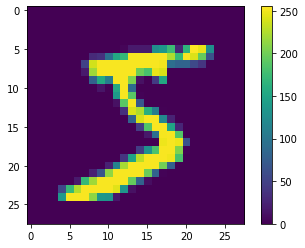

In [47]:
plt.imshow(x[0].numpy())
plt.colorbar()
plt.show()

We have a 10 class problem, numbers ranging from 0 to 9

In [52]:
n_class = len(y.unique())
y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We now one-hot encode to rearrange the problem in a suitable way for cross-entropy loss function

In [54]:
y_new = F.one_hot(y, num_classes = n_class)
y_new.shape

torch.Size([60000, 10])

In [63]:
print("First obs is a 5 --->", y[0])
print("First obs is a 5 --->", y_new[0])

First obs is a 5 ---> tensor(5)
First obs is a 5 ---> tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


As far as the x concern, we want the format to be a tensor in the form of vector, not a matrix. So instead of a 28x28 tensor, a $28^2 = 784$ tensor vector. \
We can do it with .view()

In [68]:
x.view(-1,28**2).shape

torch.Size([60000, 784])

### Build Pytorch Dataset class

Fundamental so that we can use some of classical python functions

In [72]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x/255.
        self.y = F.one_hot(self.y, num_classes = n_class).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [75]:
train_ds = CTDataset("C:/Users/Samuele/Downloads/MNIST/processed/training.pt")
test_ds = CTDataset("C:/Users/Samuele/Downloads/MNIST/processed/test.pt")

In [76]:
len(train_ds)

60000

In [79]:
#train_ds[0] #first image

### Pytorch DataLoader Object

The DataLoader allow us to work with the Dataset class into batches. In this case we set batches of size 5. So the DataSet is "split" into batches of 5 images, meaning a total of 12000 groups.

In [80]:
train_dl = DataLoader(train_ds, batch_size = 5)

In [81]:
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([5, 28, 28])
torch.Size([5, 10])


In [82]:
len(train_dl)

12000

### Define Cross Entropy Loss

In [83]:
L = nn.CrossEntropyLoss()

In [97]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [98]:
f = NeuralNetwork()

### Training

In [102]:
import time

In [104]:
def train_model(dl, f, n_epochs = 30):
    # Optimization
    opt = SGD(f.parameters(), lr = 0.01)
    L = nn.CrossEntropyLoss()
    # Train Model
    losses = []
    epochs = []
    for epoch in range(n_epochs):
        start = time.time()
        N = len(dl)
        for i, (x,y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad()
            loss_value = L(f(x),y)
            loss_value.backward()
            opt.step()
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
        end = time.time()
        print(f'Epoch {epoch} completed,', round(end-start,2), 'seconds')
    return np.array(epochs), np.array(losses)

In [105]:
epoch_data, loss_data = train_model(train_dl,f)

Epoch 0 completed, 14.88 seconds
Epoch 1 completed, 14.72 seconds
Epoch 2 completed, 13.32 seconds
Epoch 3 completed, 13.71 seconds
Epoch 4 completed, 13.63 seconds
Epoch 5 completed, 13.53 seconds
Epoch 6 completed, 13.6 seconds
Epoch 7 completed, 13.56 seconds
Epoch 8 completed, 13.55 seconds
Epoch 9 completed, 13.37 seconds
Epoch 10 completed, 13.85 seconds
Epoch 11 completed, 13.38 seconds
Epoch 12 completed, 13.54 seconds
Epoch 13 completed, 13.71 seconds
Epoch 14 completed, 13.59 seconds
Epoch 15 completed, 13.58 seconds
Epoch 16 completed, 13.38 seconds
Epoch 17 completed, 13.4 seconds
Epoch 18 completed, 13.28 seconds
Epoch 19 completed, 13.61 seconds
Epoch 20 completed, 13.59 seconds
Epoch 21 completed, 13.84 seconds
Epoch 22 completed, 13.4 seconds
Epoch 23 completed, 13.59 seconds
Epoch 24 completed, 13.27 seconds
Epoch 25 completed, 13.24 seconds
Epoch 26 completed, 13.34 seconds
Epoch 27 completed, 13.32 seconds
Epoch 28 completed, 13.78 seconds
Epoch 29 completed, 13.34 s

Average (batch-wised) cross entropy loss per epoch. Of course we could have choose less epochs here.

Text(0.5, 1.0, 'Cross Entropy (avgd per epoch)')

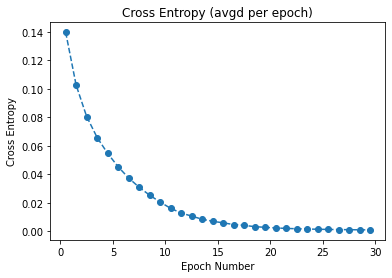

In [106]:
epoch_data_avgd = epoch_data.reshape(30,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(30,-1).mean(axis=1)
plt.plot(epoch_data_avgd, loss_data_avgd, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (avgd per epoch)')

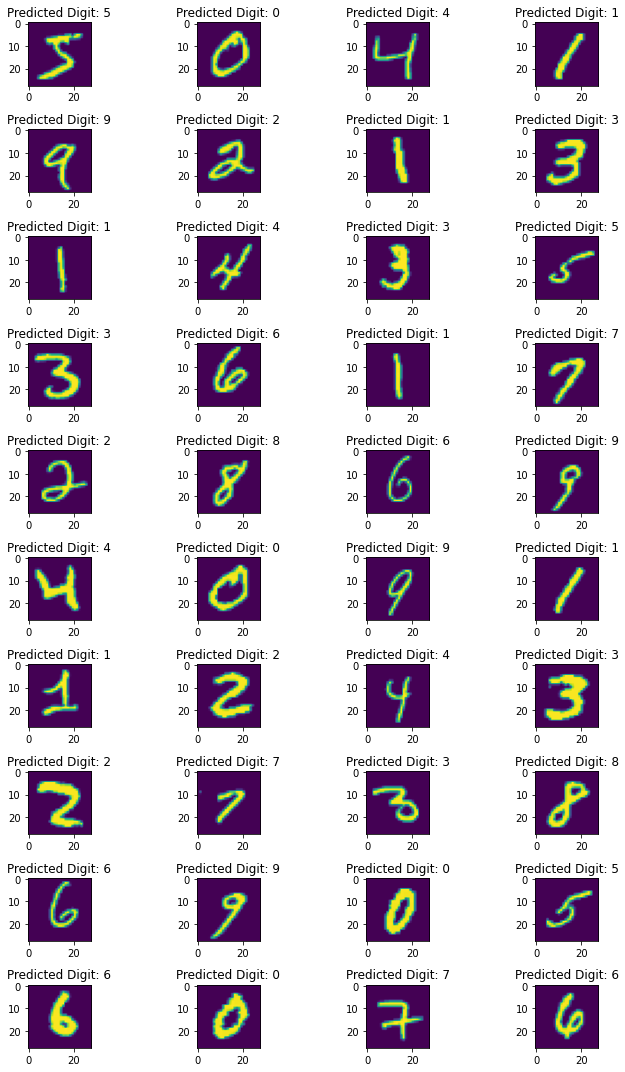

In [109]:
xs, ys = train_ds[0:1000]
yhats = f(xs).argmax(axis=1)
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()



### Test set

In [123]:
xs, ys = test_ds[:10000]
yhats = f(xs).argmax(axis=1)

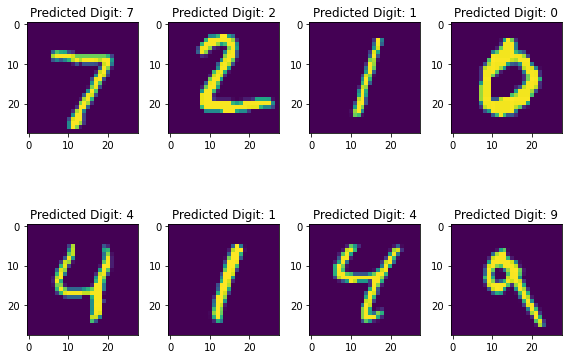

In [131]:
fig, ax = plt.subplots(2,4,figsize=(8,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()

In [170]:
x, y = torch.load("C:/Users/Samuele/Downloads/MNIST/processed/test.pt")

In [173]:
from sklearn.metrics import accuracy_score
print(accuracy_score(yhats,y)*100, "% of accuracy") 

97.91 % of accuracy
